# Accessibility API

Wrap accessibility computation into custom classes with simple API.

In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import joblib

from indicators import Accessibility

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_13704/1239877917.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
data_folder = "/Users/martin/Library/CloudStorage/OneDrive-SharedLibraries-TheAlanTuringInstitute/Daniel Arribas-Bel - demoland_data"

Load the travel time matrix.

In [3]:
ttm = pd.read_parquet(f"{data_folder}/processed/accessibility/ttm_complete.parquet")

Convert the matrix to boolean xarray.DataArray.

In [5]:
ttm = ttm.set_index(["from_id", "to_id"])
ttm.columns = ["transit", "car", "bike", "walk"]
ttm.columns.name = "mode"
ttm_arr = xr.DataArray.from_series(ttm.stack())
ttm_15 = ttm_arr <= 15
ttm_15.name = "ttm_15"

Load Workplace zone population.

In [6]:
wpz_population = pd.read_csv(f"{data_folder}/processed/accessibility/wpz_tynewear_occupation_edited.csv").rename(columns={"wpz11cd": "to_id"}).set_index("to_id")["pop"]

Merge with the traveltime matrix to create a baseline.

In [7]:
da = xr.DataArray.from_series(wpz_population)
da.name = "wpz_population"
baseline = xr.merge([ttm_15, da])
baseline["wpz_population"] = baseline["wpz_population"].fillna(0)

Load greenspace data.

In [8]:
greenspace_file = f"{data_folder}/processed/accessibility/greenspace_tynewear_edited.gpkg"
gs_entrances = gpd.read_file(greenspace_file,
                        layer = "access_points").rename(columns={'id':'to_id'})
gs_sites = gpd.read_file(greenspace_file,
                         layer = "sites").rename(columns={'id':'id_site'})
gs_sites['area_m2'] = gs_sites['geometry'].area
gs_entrances_with_parkarea = pd.merge(gs_entrances[['to_id','refToGreenspaceSite']],
                                gs_sites[['id_site', 'function','area_m2']],
                                left_on='refToGreenspaceSite',
                                right_on='id_site',
                                how='left'
                                ).set_index("to_id")

In [9]:
areas = xr.DataArray.from_series(gs_entrances_with_parkarea.area_m2)
areas.name = "greenspace_area"
site_ids = xr.DataArray.from_series(gs_entrances_with_parkarea.id_site)
site_ids.name = "greenspace_site_ids"

In [10]:
baseline = xr.merge([baseline, areas, site_ids])
baseline["greenspace_area"] = baseline["greenspace_area"].fillna(0)

In [11]:
baseline

<xarray.Dataset>
Dimensions:              (from_id: 3795, to_id: 9254, mode: 4)
Coordinates:
  * from_id              (from_id) object 'E00041363' ... 'E00175605'
  * to_id                (to_id) object 'E00041363' ... 'idFFE0D1A6-2B10-40AE...
  * mode                 (mode) object 'transit' 'car' 'bike' 'walk'
Data variables:
    ttm_15               (from_id, to_id, mode) bool True True ... False False
    wpz_population       (to_id) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    greenspace_area      (to_id) float64 0.0 0.0 0.0 ... 3.106e+04 3.09e+04
    greenspace_site_ids  (to_id) object nan ... 'idE56DE6D7-202D-13A9-E053-AA...

Create a wrapper class.

In [12]:
acc = Accessibility(baseline)

Test the object on example input.

Create random OA data.

In [19]:
oa_data = pd.Series(np.random.randint(-100, 100, len(baseline.from_id)), index=baseline.from_id.values, name="oa")
oa_data.index.name = "to_id"

In [20]:
oa_data

to_id
E00041363    98
E00041364    93
E00041366   -93
E00041367    -8
E00041368   -83
             ..
E00175601   -47
E00175602     3
E00175603     5
E00175604    69
E00175605   -45
Name: oa, Length: 3795, dtype: int64

Compute accessibility.

In [21]:
acc.job_accessibility(oa_data, "walk")

<xarray.DataArray 'combined' (from_id: 3795)>
array([10211., 11166.,  3098., ...,  1113.,  1714.,   324.])
Coordinates:
    mode     <U4 'walk'
  * from_id  (from_id) object 'E00041363' 'E00041364' ... 'E00175605'

Save the custom class to a compressed joblib.

In [23]:
with open(f"{data_folder}/models/accessibility.joblib", "wb") as f:
    joblib.dump(acc, f, compress=True)

Test loaded class

In [11]:
with open(f"{data_folder}/models/accessibility.joblib", "rb") as f:
    acc2 = joblib.load(f)

In [75]:
oa_data = pd.Series(0, index=acc2.baseline.from_id.values, name="oa")
oa_data.index.name = "to_id"

In [77]:
job_acc = acc2.job_accessibility(oa_data, "walk")

In [80]:
orig_data = pd.read_csv(f"{data_folder}/outputs/results_accessibility/acc_jobs15_OAtoWPZ_tynewear.csv", index_col=0)

In [81]:
orig_data

,from_id,A_pop_cum_15
0,E00041363,4318
1,E00041364,7604
2,E00041366,845
3,E00041367,3413
4,E00041368,1728
...,...,...
3790,E00175601,2100
3791,E00175602,296
3792,E00175603,1036
3793,E00175604,296


In [91]:
job_acc.to_pandas().to_frame()

,0
from_id,
E00041363,9237.0
E00041364,10482.0
E00041366,2443.0
E00041367,8438.0
E00041368,1710.0
...,...
E00175601,2588.0
E00175602,1344.0
E00175603,842.0


In [84]:
geoms = gpd.read_file(f"{data_folder}/processed/authorities/OA_TyneWear.gpkg")

In [87]:
geoms

,geo_code,geometry
0,E00042786,"POLYGON ((428997.799 566018.331, 428998.491 56..."
1,E00042707,"POLYGON ((424221.655 568003.052, 424221.754 56..."
2,E00042703,"POLYGON ((419858.836 565454.433, 419858.374 56..."
3,E00042782,"POLYGON ((428932.199 566299.133, 428933.629 56..."
4,E00042789,"POLYGON ((428853.730 565689.295, 428860.602 56..."
...,...,...
3790,E00041811,"POLYGON ((428782.519 562282.321, 428783.470 56..."
3791,E00041818,"POLYGON ((416764.269 564158.045, 416764.216 56..."
3792,E00041898,"POLYGON ((423738.129 560286.484, 423738.500 56..."
3793,E00041819,"POLYGON ((415843.233 564846.473, 415868.526 56..."


In [88]:
geoms = geoms.merge(orig_data, left_on="geo_code", right_on="from_id")

<AxesSubplot: >

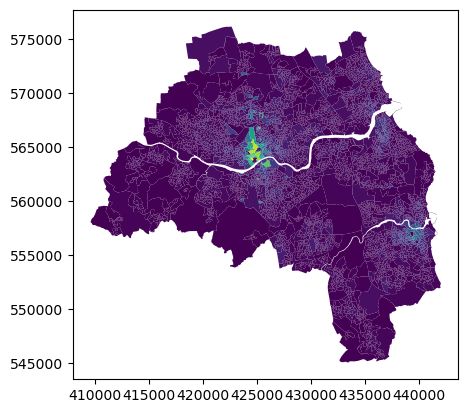

In [90]:
geoms.plot("A_pop_cum_15")

In [92]:
geoms = geoms.merge(job_acc.to_pandas().to_frame(), left_on="geo_code", right_on="from_id")

In [93]:
geoms

,geo_code,geometry,from_id,A_pop_cum_15,0
0,E00042786,"POLYGON ((428997.799 566018.331, 428998.491 56...",E00042786,1823,2313.0
1,E00042707,"POLYGON ((424221.655 568003.052, 424221.754 56...",E00042707,5415,12862.0
2,E00042703,"POLYGON ((419858.836 565454.433, 419858.374 56...",E00042703,822,1548.0
3,E00042782,"POLYGON ((428932.199 566299.133, 428933.629 56...",E00042782,2240,3310.0
4,E00042789,"POLYGON ((428853.730 565689.295, 428860.602 56...",E00042789,527,2267.0
...,...,...,...,...,...
3790,E00041811,"POLYGON ((428782.519 562282.321, 428783.470 56...",E00041811,261,1370.0
3791,E00041818,"POLYGON ((416764.269 564158.045, 416764.216 56...",E00041818,1709,1750.0
3792,E00041898,"POLYGON ((423738.129 560286.484, 423738.500 56...",E00041898,10939,2310.0
3793,E00041819,"POLYGON ((415843.233 564846.473, 415868.526 56...",E00041819,654,1216.0


<AxesSubplot: >

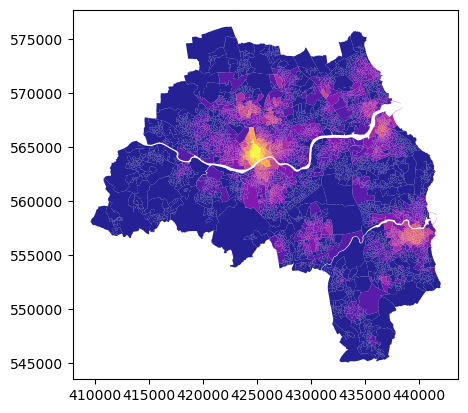

In [97]:
geoms.plot(0, scheme="naturalbreaks", k=10, alpha=.9, cmap="plasma")

<AxesSubplot: >

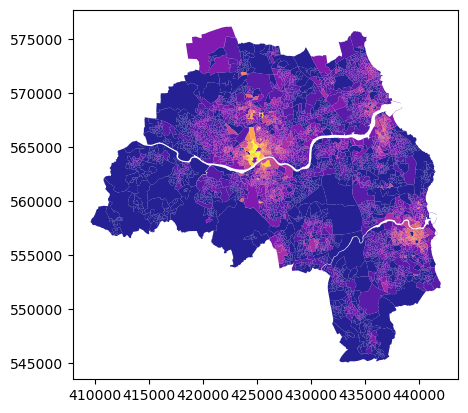

In [98]:
geoms.plot("A_pop_cum_15", scheme="naturalbreaks", k=10, alpha=.9, cmap="plasma")

<AxesSubplot: ylabel='Frequency'>

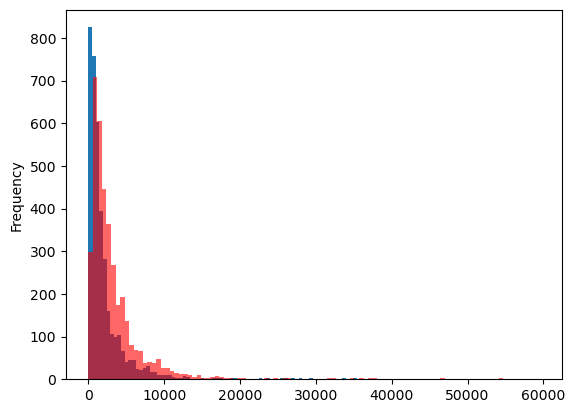

In [99]:
ax = geoms.A_pop_cum_15.plot.hist(bins=100)
geoms[0].plot.hist(bins=100, ax=ax, color='r', alpha=.6)